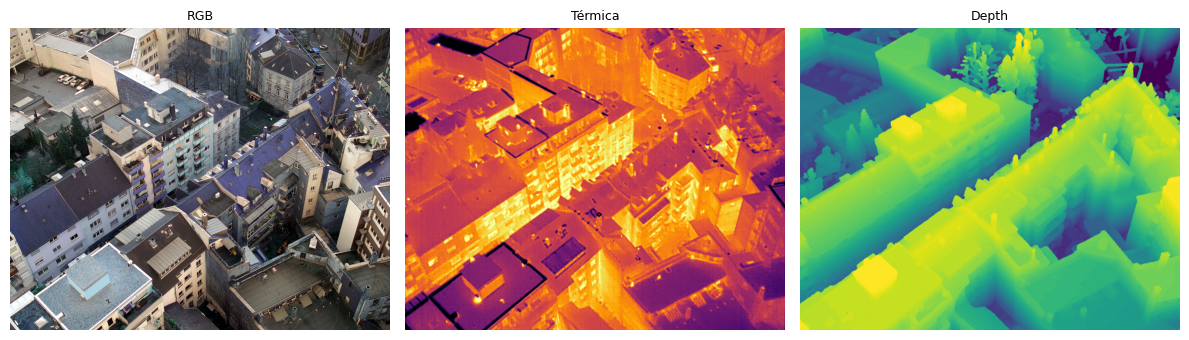

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from ultralytics import YOLO
from utils import box_iou,compute_map

BASE = Path.home() / "ProyectoFinalVA"
SPLITS_DIR = BASE / "img_splits"
MODE1 = "HST"
MODE2 = "GST"
YOLO_IMAGES_DIR1 = BASE / f"YOLO/{MODE1}/images/train"
YOLO_IMAGES_DIR2 = BASE / f"YOLO/{MODE2}/images/train"

SEED = 0
random.seed(SEED)

N_SPLIT = 1
N_YOLO = 3

CMAP_THERM = 'inferno'
CMAP_DEPTH = 'viridis'
def robust01(x, lo=1.0, hi=99.0):
    x = x.astype(np.float32)
    finite = np.isfinite(x)
    if not finite.any():
        return np.zeros_like(x, dtype=np.float32)
    lo_v, hi_v = np.percentile(x[finite], [lo, hi])
    x = np.clip(x, lo_v, hi_v)
    return (x - lo_v) / (hi_v - lo_v + 1e-9)

def to_uint8_robust_rgb(rgb):
    rgb = rgb.astype(np.float32)
    p1  = np.percentile(rgb, 1, axis=(0,1))
    p99 = np.percentile(rgb, 99, axis=(0,1))
    out = (rgb - p1) / (p99 - p1 + 1e-9)
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

def load_split_paths(split_txt: Path):
    with open(split_txt) as f:
        return [Path(l.strip()) for l in f if l.strip()]

def grid_shape(n, cols=3):
    rows = (n + cols - 1) // cols
    return rows, cols
SPLIT = "train"
split_txt = SPLITS_DIR / f"{SPLIT}.txt"
paths = load_split_paths(split_txt)
sample = random.sample(paths, min(N_SPLIT, len(paths)))

rows = len(sample)
fig, axes = plt.subplots(rows, 3, figsize=(12, max(2.8 * rows, 3.5)))
if rows == 1:
    axes = np.array([axes])

for i, p in enumerate(sample):
    arr = np.load(p)
    stem = p.stem

    if arr.ndim != 3 or arr.shape[-1] < 4:
        for j in range(3):
            axes[i, j].axis('off')
        axes[i, 0].set_title(f"{stem} (formato inesperado)")
        continue

    rgb = arr[..., :3]
    rgb_u8 = to_uint8_robust_rgb(rgb)
    axes[i, 0].imshow(rgb_u8)
    axes[i, 0].set_title("RGB", fontsize=9)
    axes[i, 0].axis('off')

    therm = arr[..., 3]
    therm_n = robust01(therm)
    axes[i, 1].imshow(therm_n, cmap=CMAP_THERM)
    axes[i, 1].set_title("Térmica", fontsize=9)
    axes[i, 1].axis('off')

    if arr.shape[-1] >= 5:
        depth = arr[..., 4]
        depth_n = robust01(depth)
        axes[i, 2].imshow(depth_n, cmap=CMAP_DEPTH)
        axes[i, 2].set_title("Depth", fontsize=9)
    else:
        axes[i, 2].imshow(np.zeros_like(therm_n), cmap='gray')
        axes[i, 2].set_title("Depth: no disponible", fontsize=9)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
